# Pylops - MDD preconditioners analysis

### Author: M.Ravasi

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from IPython import display
from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from scipy.ndimage.filters import convolve1d as sp_convolve1d

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *

np.random.seed(10)

### Single virtual sources

We consider now a case with multiple virtual sources

In [2]:
###### Input parameters
par = {'ox':-300,  'dx':10,    'nx':61,
       'oy':-500,  'dy':10,    'ny':101,
       'ot':0,     'dt':0.004, 'nt':400,
       'f0': 20,   'nfmax': 200}

t0_m    = [0.4]
vrms_m  = [900.]
amp_m   = [1.]

t0_G    = np.sort(np.random.uniform(0.2, 1., 12))
vrms_G  = np.sort(np.random.uniform(900, 1500, 12))
amp_G   = np.random.uniform(-2, 2, 12)

# Create taper for operator
tap = taper3d(par['nt'], [par['ny'], par['nx']], [5,5], tapertype='hanning')

# Create axis
t, t2, x, y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
m, mwav = hyperbolic2d(x,t,t0_m,vrms_m,amp_m,wav)

# Generate operator
#G,Gwav = hyperbolic3d(x,y,t,t0_G,vrms_G,vrms_G,amp_G,wav)
G,Gwav = np.zeros((par['ny'],par['nx'],par['nt'])), np.zeros((par['ny'],par['nx'],par['nt']))
for iy,y0 in enumerate(y):
    G[iy],Gwav[iy] = hyperbolic2d(x-y0,t,t0_G,vrms_G,amp_G,wav)

G,Gwav = G*tap,Gwav*tap

In [3]:
# Add negative part to data and model
m     = np.concatenate((np.zeros((par['nx'], par['nt']-1)),    m), axis=-1)
mwav  = np.concatenate((np.zeros((par['nx'], par['nt']-1)), mwav), axis=-1)
Gwav2 = np.concatenate((np.zeros((par['ny'], par['nx'], par['nt']-1)), Gwav), axis=-1)

Gwav_fft = np.fft.rfft(Gwav2, 2*par['nt']-1, axis=-1)
Gwav_fft = Gwav_fft[...,:par['nfmax']]

MDCop=MDC(Gwav_fft.transpose(2,0,1), nt=2*par['nt']-1, nv=1, dt=par['dt'], dr=par['dx'], 
          twosided=True)
dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=3, verb=True);

# Create data
d = MDCop * m.T.flatten()
d = d.reshape(2*par['nt']-1, par['ny'])

Dot test passed, v^H(Opu)=-14379.282368244556 - u^H(Op^Hv)=-14379.282368244512


In [4]:
# No prec
madj = MDCop.H * d.ravel()
madj = madj.reshape(2*par['nt']-1, par['nx'])

# No prec
minv = MDD(Gwav2, d.T, 
           dt=par['dt'], dr=par['dx'], nfmax=par['nfmax'], wav = wav,
           twosided=True, add_negative=False, causality_precond=False,
           adjoint=False, psf=False, dottest=False, 
           **dict(damp=1e-4, iter_lim=30, show=1))

# Negtime mute preconditioner
minv_causalityprec = MDD(Gwav2, d.T, 
           dt=par['dt'], dr=par['dx'], nfmax=par['nfmax'], wav = wav,
           twosided=True, add_negative=False, causality_precond=True,
           adjoint=False, psf=False, dottest=False, 
           **dict(damp=1e-4, iter_lim=30, show=1))

# Negtime mute (with smoothing) preconditioner
minv_causalityprecsmooth = MDD(Gwav2, d.T, 
           dt=par['dt'], dr=par['dx'], nfmax=par['nfmax'], wav = wav,
           twosided=True, add_negative=False, causality_precond=True,
           adjoint=False, psf=False, dottest=False, smooth_precond=30,
           **dict(damp=1e-4, iter_lim=30, show=1))

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 80699 rows and 48739 columns
damp = 1.00000000000000e-04   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       30
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   7.894e+02  7.894e+02    1.0e+00  6.6e-01
     1  0.00000e+00   4.383e+02  4.383e+02    5.6e-01  6.6e-01   6.3e+02  1.0e+00
     2  0.00000e+00   3.070e+02  3.070e+02    3.9e-01  3.6e-01   9.0e+02  2.2e+00
     3  0.00000e+00   2.292e+02  2.292e+02    2.9e-01  2.8e-01   1.1e+03  3.7e+00
     4  0.00000e+00   1.797e+02  1.797e+02    2.3e-01  2.4e-01   1.2e+03  5.3e+00
     5  0.00000e+00   1.484e+02  1.484e+02    1.9e-01  1.6e-01   1.4e+03  7.0e+00
     6  0.00000e+00   1.300e+02  1.300e+02    1.6e-01  1.3e-01   1.5e+03  8.7e+00
     7  0.00000e+00   1.176e+02  1.176e+02    1.5e-01  1.2e-01   1.6e+03  1.1e+01
     8  0.00000e+00   1.068e+02 

In [5]:
Padop = Pad((par['nt'], par['nx']), ((par['nt']-1, 0), (0,0)))
MDCPadop = MDCop * Padop
pinv_pad = lsqr(MDCPadop, d.flatten(), damp=1e-4, iter_lim=30, show=1)[0]
minv_pad = (Padop * pinv_pad).reshape(2*par['nt']-1, par['nx']).T
minv_pad = sp_convolve1d(minv_pad, wav, axis=-1)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 80699 rows and 24400 columns
damp = 1.00000000000000e-04   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       30
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   7.894e+02  7.894e+02    1.0e+00  6.6e-01
     1  0.00000e+00   4.332e+02  4.332e+02    5.5e-01  6.4e-01   6.2e+02  1.0e+00
     2  0.00000e+00   3.032e+02  3.032e+02    3.8e-01  3.6e-01   8.7e+02  2.2e+00
     3  0.00000e+00   2.314e+02  2.314e+02    2.9e-01  2.7e-01   1.0e+03  3.6e+00
     4  0.00000e+00   1.824e+02  1.824e+02    2.3e-01  2.3e-01   1.2e+03  5.3e+00
     5  0.00000e+00   1.512e+02  1.512e+02    1.9e-01  1.5e-01   1.3e+03  7.1e+00
     6  0.00000e+00   1.354e+02  1.354e+02    1.7e-01  1.3e-01   1.4e+03  8.7e+00
     7  0.00000e+00   1.233e+02  1.233e+02    1.6e-01  1.2e-01   1.6e+03  1.1e+01
     8  0.00000e+00   1.114e+02 

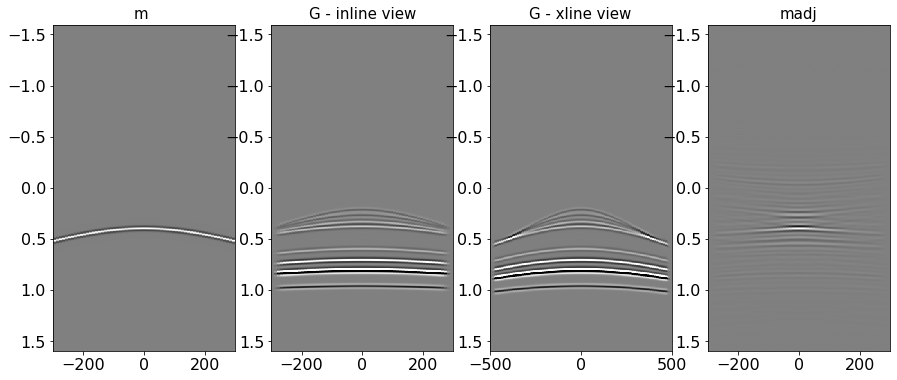

In [6]:
# Plotting
fig, axs = plt.subplots(1, 4, figsize=(15,6))
axs[0].imshow(mwav.T,aspect='auto',interpolation='nearest', cmap='gray',
              extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-mwav.max(), vmax=mwav.max())
axs[0].set_title('m ', fontsize=15)
axs[1].imshow(Gwav2[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-mwav.max(), vmax=mwav.max())
axs[1].set_title('G - inline view', fontsize=15)
axs[2].imshow(Gwav2[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()), vmin=-mwav.max(), vmax=mwav.max())
axs[2].set_title('G - xline view', fontsize=15)
axs[3].imshow(d, aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-d.max(), vmax=d.max())
axs[3].set_title('d', fontsize=15)
axs[3].imshow(madj, aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-madj.max(), vmax=madj.max())
axs[3].set_title('madj', fontsize=15);

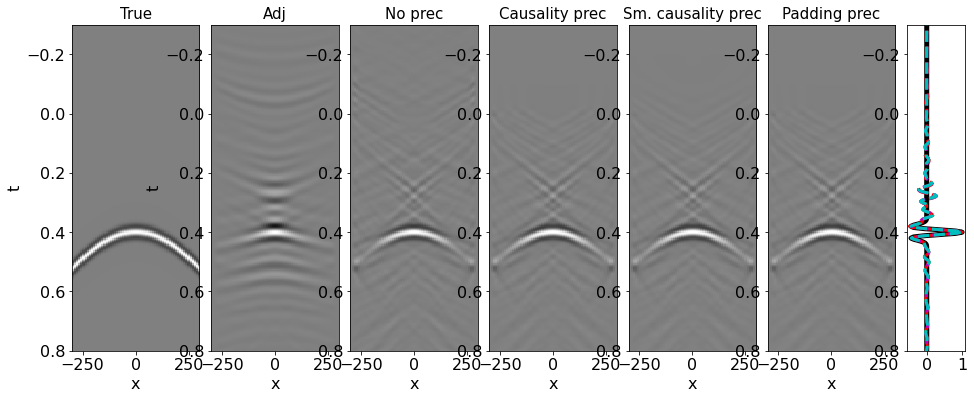

In [7]:
fig = plt.figure(figsize=(16, 6))
ax0 = plt.subplot2grid((1, 13), (0, 0), colspan=2)
ax1 = plt.subplot2grid((1, 13), (0, 2), colspan=2)
ax2 = plt.subplot2grid((1, 13), (0, 4), colspan=2)
ax3 = plt.subplot2grid((1, 13), (0, 6), colspan=2)
ax4 = plt.subplot2grid((1, 13), (0, 8), colspan=2)
ax5 = plt.subplot2grid((1, 13), (0, 10), colspan=2)
ax6 = plt.subplot2grid((1, 13), (0, 12))

ax0.imshow(mwav.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-mwav.max(), vmax=mwav.max())
ax0.set_title('True', fontsize=15)
ax0.set_xlabel('x'),ax0.set_ylabel('t')
ax0.set_ylim(.8,-.3)
ax1.imshow(madj,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-madj.max(), vmax=madj.max())
ax1.set_title('Adj', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')
ax1.set_ylim(.8,-.3)
ax2.imshow(minv.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-mwav.max(), vmax=mwav.max())
ax2.set_title('No prec', fontsize=15)
ax2.set_xlabel('x')
ax2.set_ylim(.8,-.3)
ax3.imshow(minv_causalityprec.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-mwav.max(), vmax=mwav.max())
ax3.set_title('Causality prec', fontsize=15)
ax3.set_xlabel('x')
ax3.set_ylim(.8,-.3)
ax4.imshow(minv_causalityprecsmooth.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-mwav.max(), vmax=mwav.max())
ax4.set_title('Sm. causality prec', fontsize=15)
ax4.set_xlabel('x')
ax4.set_ylim(.8,-.3)
ax5.imshow(minv_pad.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-mwav.max(), vmax=mwav.max())
ax5.set_title('Padding prec', fontsize=15)
ax5.set_xlabel('x')
ax5.set_ylim(.8,-.3)

ax6.plot(mwav[int(par['nx']/2)]/np.abs(mwav[int(par['nx']/2)]).max(), t2, 'k',   lw=5)
ax6.plot(minv[int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--r', lw=3)
ax6.plot(minv_causalityprec[int(par['nx']/2)]/np.abs(minv_causalityprec[int(par['nx']/2)]).max(), t2, '--g', lw=3)
ax6.plot(minv_causalityprecsmooth[int(par['nx']/2)]/np.abs(minv_causalityprecsmooth[int(par['nx']/2)]).max(), t2, '--m', lw=3)
ax6.plot(minv_pad[int(par['nx']/2)]/np.abs(minv_pad[int(par['nx']/2)]).max(), t2, '--c', lw=3)
ax6.set_ylim(.8,-.3);

In [8]:
niters=30
off_time = 50

minv_history = np.zeros((niters, par['nx'], 2*par['nt']-1))
minv_causalityprec_history = np.zeros((niters, par['nx'], 2*par['nt']-1))
minv_causalityprecsmooth_history = np.zeros((niters, par['nx'], 2*par['nt']-1))
minv_causalitypad_history = np.zeros((niters, par['nx'], 2*par['nt']-1))

res_history = np.zeros(niters)
res_causalityprec_history = np.zeros(niters)
res_causalityprecsmooth_history = np.zeros(niters)
res_causalitypad_history = np.zeros(niters)
err_history = np.zeros(niters)
err_causalityprec_history = np.zeros(niters)
err_causalityprecsmooth_history = np.zeros(niters)
err_causalitypad_history = np.zeros(niters)

for iiter in range(niters):
    # No prec
    minv_history[iiter] = MDD(Gwav2, d.T, 
                               dt=par['dt'], dr=par['dx'], nfmax=par['nfmax'], wav = wav,
                               twosided=True, add_negative=False, causality_precond=False,
                               adjoint=False, psf=False, dottest=False, 
                               **dict(damp=1e-4, iter_lim=iiter+1, show=0))
    res = (MDCop * mwav.T.ravel() - MDCop * minv_history[iiter].T.ravel()).reshape(2*par['nt']-1, par['ny'])
    res_history[iiter] = np.linalg.norm(res[par['nt']+off_time:])
    err_history[iiter] = np.linalg.norm(mwav[:, par['nt']+off_time:] - minv_history[iiter, :, par['nt']+off_time:])
    
    # Negtime mute preconditioner
    minv_causalityprec_history[iiter] = MDD(Gwav2, d.T, 
                                            dt=par['dt'], dr=par['dx'], nfmax=par['nfmax'], wav = wav,
                                            twosided=True, add_negative=False, causality_precond=True,
                                            adjoint=False, psf=False, dottest=False, 
                                            **dict(damp=1e-4, iter_lim=iiter+1, show=0))
    res = (MDCop * mwav.T.ravel() - MDCop * minv_causalityprec_history[iiter].T.ravel()).reshape(2*par['nt']-1, par['ny'])
    res_causalityprec_history[iiter] = np.linalg.norm(res[par['nt']+off_time:])
    err_causalityprec_history[iiter] = np.linalg.norm(mwav[:, par['nt']+off_time:] - minv_causalityprec_history[iiter, :, par['nt']+off_time:])
    
    # Negtime smooth mute preconditioner
    minv_causalityprecsmooth_history[iiter] = MDD(Gwav2, d.T, 
                                            dt=par['dt'], dr=par['dx'], nfmax=par['nfmax'], wav = wav,
                                            twosided=True, add_negative=False, causality_precond=True,
                                            adjoint=False, psf=False, dottest=False, 
                                            smooth_precond=20, **dict(damp=1e-4, iter_lim=iiter+1, show=0))
    res = (MDCop * mwav.T.ravel() - MDCop * minv_causalityprecsmooth_history[iiter].T.ravel()).reshape(2*par['nt']-1, par['ny'])
    res_causalityprecsmooth_history[iiter] = np.linalg.norm(res[par['nt']+off_time:])
    err_causalityprecsmooth_history[iiter] = np.linalg.norm(mwav[:, par['nt']+off_time:] - minv_causalityprecsmooth_history[iiter, :, par['nt']+off_time:])
    
    # Pad preconditioner
    pinv_pad = lsqr(MDCPadop, d.flatten(), damp=1e-4, iter_lim=iiter+1, show=0)[0]
    minv_causalitypad_history[iiter] = (Padop * pinv_pad).reshape(2*par['nt']-1, par['nx']).T
    minv_causalitypad_history[iiter] = sp_convolve1d(minv_causalitypad_history[iiter], wav, axis=-1)
    res = (MDCop * mwav.T.ravel() - MDCop * minv_causalitypad_history[iiter].T.ravel()).reshape(2*par['nt']-1, par['ny'])
    res_causalitypad_history[iiter] = np.linalg.norm(res[par['nt']+off_time:])
    err_causalitypad_history[iiter] = np.linalg.norm(mwav[:, par['nt']+off_time:] - minv_causalitypad_history[iiter, :, par['nt']+off_time:])

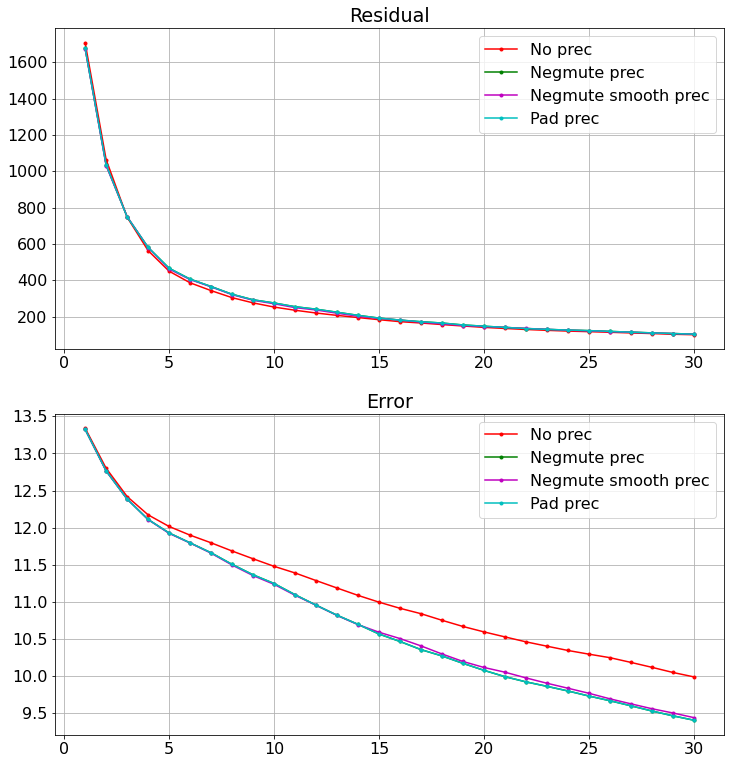

In [9]:
fig,(ax1, ax2) = plt.subplots(2,1,figsize=(12, 13))
ax1.plot(np.arange(niters)+1, res_history, '.-r', label='No prec')
ax1.plot(np.arange(niters)+1, res_causalityprec_history, '.-g', label='Negmute prec')
ax1.plot(np.arange(niters)+1, res_causalityprecsmooth_history, '.-m', label='Negmute smooth prec')
ax1.plot(np.arange(niters)+1, res_causalitypad_history, '.-c', label='Pad prec')

ax1.set_title('Residual')
ax1.legend()
ax1.grid()
ax2.plot(np.arange(niters)+1, err_history, '.-r', label='No prec')
ax2.plot(np.arange(niters)+1, err_causalityprec_history, '.-g', label='Negmute prec')
ax2.plot(np.arange(niters)+1, err_causalityprecsmooth_history, '.-m', label='Negmute smooth prec')
ax2.plot(np.arange(niters)+1, err_causalitypad_history, '.-c', label='Pad prec')
ax2.set_title('Error')
ax2.legend();
ax2.grid()

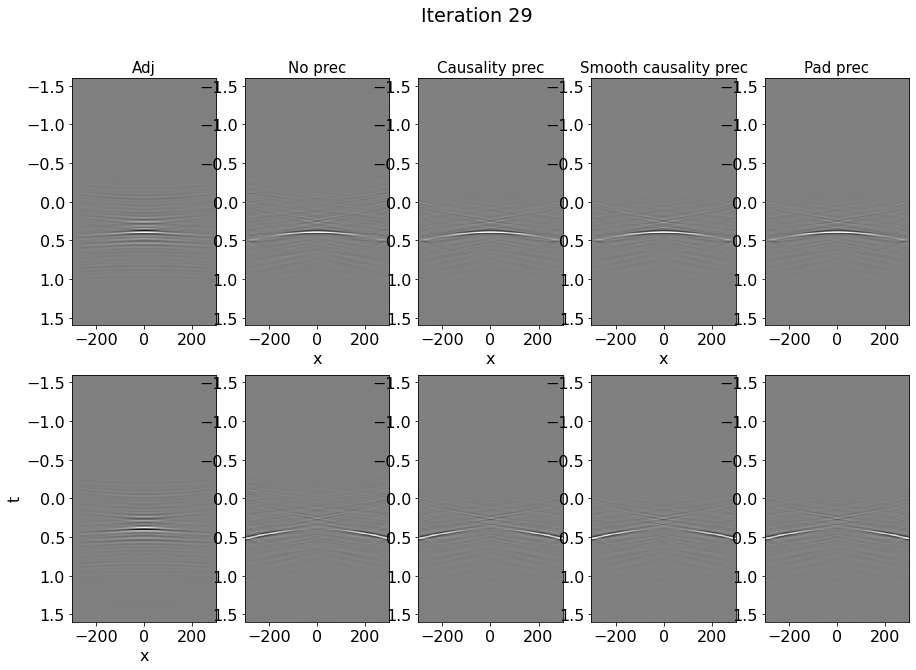

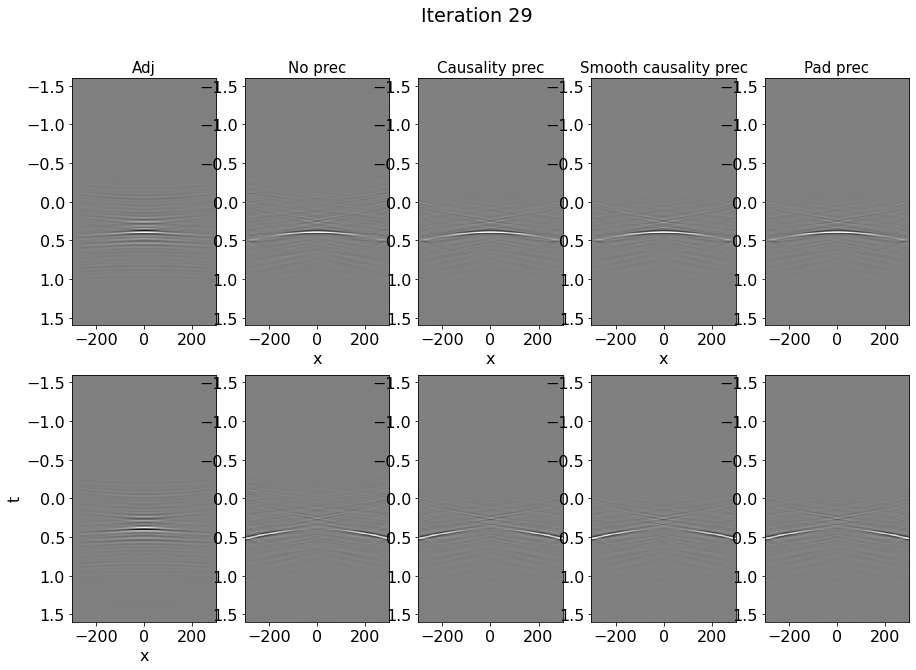

In [10]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax12, ax22, ax32, ax42, ax52)) = plt.subplots(2, 5, figsize=(15, 10))
ax1.imshow(madj, aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-madj.max(), vmax=madj.max())
ax12.imshow(mwav.T - madj, aspect='auto',interpolation='nearest', cmap='gray',
            extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-madj.max(), vmax=madj.max())
ax1.set_title('Adj', fontsize=15)
ax12.set_xlabel('x'),ax12.set_ylabel('t')
#ax1.set_ylim(.8,-.3)
#ax12.set_ylim(.8,-.3)
ax2.set_title('No prec', fontsize=15)
ax2.set_xlabel('x')
#ax2.set_ylim(.8,-.3)
#ax22.set_ylim(.8,-.3)
ax3.set_title('Causality prec', fontsize=15)
ax3.set_xlabel('x')
#ax3.set_ylim(.8,-.3)
#ax32.set_ylim(.8,-.3)
ax4.set_title('Smooth causality prec', fontsize=15)
ax4.set_xlabel('x')
#ax4.set_ylim(.8,-.3)
#ax42.set_ylim(.8,-.3)
ax5.set_title('Pad prec', fontsize=15)
#ax52.set_xlabel('x')
#ax5.set_ylim(.8,-.3)
#ax52.set_ylim(.8,-.3)

for iiter in range(0, niters, 2):
    ax2.imshow(minv_history[iiter].T,aspect='auto',interpolation='nearest', cmap='gray',
               extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-mwav.max(), vmax=mwav.max())
    ax3.imshow(minv_causalityprec_history[iiter].T,aspect='auto',interpolation='nearest', cmap='gray',
               extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-mwav.max(), vmax=mwav.max())
    ax4.imshow(minv_causalityprecsmooth_history[iiter].T,aspect='auto',interpolation='nearest', cmap='gray',
               extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-mwav.max(), vmax=mwav.max())
    ax5.imshow(minv_causalitypad_history[iiter].T,aspect='auto',interpolation='nearest', cmap='gray',
               extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-mwav.max(), vmax=mwav.max())
    ax22.imshow(mwav.T-minv_history[iiter].T,aspect='auto',interpolation='nearest', cmap='gray',
                extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-mwav.max(), vmax=mwav.max())
    ax32.imshow(mwav.T-minv_causalityprec_history[iiter].T,aspect='auto',interpolation='nearest', cmap='gray',
                extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-mwav.max(), vmax=mwav.max())
    ax42.imshow(mwav.T-minv_causalityprecsmooth_history[iiter].T,aspect='auto',interpolation='nearest', cmap='gray',
                extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-mwav.max(), vmax=mwav.max())
    ax52.imshow(mwav.T-minv_causalitypad_history[iiter].T,aspect='auto',interpolation='nearest', cmap='gray',
                extent=(x.min(),x.max(),t2.max(),t2.min()), vmin=-mwav.max(), vmax=mwav.max())
    fig.suptitle('Iteration %d' % (iiter +1))
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
    time.sleep(0.2) 